# SVD

## Import libraries

In [1]:
from lib.models import RecommendSystemModel

from typing import List, Any, Tuple,Union
from numpy.typing import NDArray
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange, typed, types

# import tensorflow as tf
np.random.seed(3362)
import sys
print(sys.version)
print(sys.version_info)
import time

3.7.13 (default, Oct 19 2022, 10:19:43) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)


## Function to update class in Jupyter Notebook 
https://stackoverflow.com/questions/45161393/jupyter-split-classes-in-multiple-cells

In [2]:
import functools
def update_class(
    main_class=None, exclude=("__module__", "__name__", "__dict__", "__weakref__")
):
    """Class decorator. Adds all methods and members from the wrapped class to main_class

    Args:
    - main_class: class to which to append members. Defaults to the class with the same name as the wrapped class
    - exclude: black-list of members which should not be copied
    """

    def decorates(main_class, exclude, appended_class):
        if main_class is None:
            main_class = globals()[appended_class.__name__]
        for k, v in appended_class.__dict__.items():
            if k not in exclude:
                setattr(main_class, k, v)
        return main_class

    return functools.partial(decorates, main_class, exclude)

### Example

In [3]:
class MyClass:
    def method1(self):
        print("method1")
me = MyClass()


In [4]:
@update_class()
class MyClass:
    def method2(self):
        print("method2")
me.method1()
me.method2()

method1
method2


## The ML model

In [5]:
class SVDModel(RecommendSystemModel):
    def __init__(
        self,
        mode: str = None,
        features: int = None,
        lr: float = None,
        epochs: int = None,
        weight_decay: float = None,
        stopping: float = None,
        momentum: float = None,
    ) -> None:
        super().__init__(mode, features, lr, epochs, weight_decay, stopping, momentum)



In [6]:
@update_class()
class SVDModel(RecommendSystemModel):
    def split(
        self, ratio_train_test: float, ratio_train_valid: float
    ) -> None:
        userItemMatrix = (
            self.data[["userId", "movieId", "rating"]]
            .pivot_table(columns="movieId", index="userId", values="rating")
            .fillna(0)
        )
        userItemMatrix = userItemMatrix.to_numpy()

        print(f"User Item Matrix Shape: {userItemMatrix.shape}")
        print(f"User Reference length: {self.n_users}")
        print(f"Item Reference length: {self.n_items}")

        self.train, self.valid, self.test =  _split(ratio_train_test, ratio_train_valid, userItemMatrix, self.n_users, self.n_items)

@njit(parallel=True, fastmath=True)
def _split(
    ratio_train_test: float, ratio_train_valid: float, userItemMatrix, n_users, n_items):

    trainBeforeSplit = userItemMatrix.copy()
    trainBeforeSplit.fill(0)

    train = trainBeforeSplit.copy()
    valid = trainBeforeSplit.copy()
    test = trainBeforeSplit.copy()

    for i in prange(n_users):
        for j in prange(n_items):
            if userItemMatrix[i, j]:
                if np.random.binomial(1, ratio_train_test, 1):
                    if np.random.binomial(1, ratio_train_valid, 1):
                        train[i, j] = userItemMatrix[i, j]
                    else:
                        valid[i, j] = userItemMatrix[i, j]
                else:
                    test[i, j] = userItemMatrix[i, j]
    
    return train, valid, test

In [7]:
@update_class()
class SVDModel(RecommendSystemModel):
    def data_loader(
        self,
        path: str = None,
        nrows: int = None,
        skiprows=None,
        data: pd.DataFrame = None,
    ) -> None:
        if not path and data.empty:
            raise "Error: one of path or data frame should be provided"
        if data.empty:
            self.data = pd.read_csv(
                path, low_memory=False, nrows=nrows, skiprows=skiprows
            )
        elif not path:
            self.data = data

        # create reference of users and movies
        self.users_ref = self.data["userId"].unique()
        self.users_ref.sort()
        self.movies_ref = self.data["movieId"].unique()
        self.movies_ref.sort()

        self.n_users = len(self.users_ref)
        self.n_items = len(self.movies_ref)

In [8]:

@update_class()
class SVDModel(RecommendSystemModel):
    def train_one_epoch(self):
        return _train_one_epoch(
            self.n_users,
            self.n_items,
            self.train,
            self._P,
            self._Q,
            self.mode,
            self._mean,
            self._bu,
            self._bi,
            self.lr,
            self.weight_decay,
        )

    def training(self) -> Tuple[NDArray, NDArray, float, float]:
        loss_train = []
        loss_valid = []
        errors = []

        self._P = np.random.rand(self.n_users, self.features) * 0.1
        self._Q = np.random.rand(self.n_items, self.features) * 0.1
        self._bu = np.zeros(self.n_users)
        self._bi = np.zeros(self.n_items)
        self._mean = 0
        if self.mode == "svd++":
            # for advanced SVD
            self._bu = np.zeros(self.n_users)
            self._bi = np.zeros(self.n_items)
            self._mean = np.mean(self.data["rating"])
        # Johnny
        tic = time.perf_counter()
        for e in range(self.epochs):
            error = self.train_one_epoch()
            errors.append(error)

            trainLoss = self.loss(self.train)
            validLoss = self.loss(self.valid)
            loss_train.append(trainLoss)
            loss_valid.append(validLoss)

            if e % 10 == 0:
                toc = time.perf_counter()
                print(
                    "Epoch : ",
                    "{:3.0f}".format(e + 1),
                    " | Train :",
                    "{:3.3f}".format(trainLoss),
                    " | Valid :",
                    "{:3.3f}".format(validLoss),
                    " | Time :",
                    "{:3.5f}s".format(toc - tic),
                )
                tic = time.perf_counter()

            if e > 2:
                if abs(validLoss - loss_valid[-2]) < self.stopping:
                    break
        print("Training stopped:")
        testLoss = self.loss(self.test)
        print(
            "Epoch : ",
            "{:3.0f}".format(e + 1),
            " | Train Loss :",
            "{:3.3f}".format(trainLoss),
            " | Valid Loss:",
            "{:3.3f}".format(validLoss),
            " | Test Loss:",
            "{:3.3f}".format(testLoss),
        )

        return loss_train, loss_valid, testLoss, errors
    

@njit(parallel=True, fastmath=True)
def _train_one_epoch(n_users, n_items, train, _P, _Q, mode, _mean, _bu, _bi, lr, weight_decay):
    error = 0
    for id_user in prange(n_users):
        for id_item in prange(n_items):
            if train[id_user, id_item] > 0:
                # Predict
                predict = np.dot(_P[id_user, :], _Q[id_item, :])
                if mode == "svd++":
                    predict += _mean + _bu[id_user] + _bi[id_item]

                error = train[id_user, id_item] - predict

                if mode == "svd++":
                    _bu[id_user] += lr * (error - weight_decay * _bu[id_user])
                    _bi[id_item] += lr * (error - weight_decay * _bi[id_item])

                _P[id_user, :] += lr * (
                    error * _Q[id_item, :] - weight_decay * _P[id_user, :]
                )
                _Q[id_item, :] += lr * (
                    error * _P[id_user, :] - weight_decay * _Q[id_item, :]
                )

    return error


In [9]:
@update_class()
class SVDModel(RecommendSystemModel):
    def prediction(self, u: int, i: int) -> float:
        # Woody
        return _prediction(u, i, self._P, self._Q, self._mean, self._bu, self._bi, self.mode)

@njit(parallel=True, fastmath=True)
def _prediction( u: int, i: int, _P, _Q, _mean, _bu, _bi, mode):
    # Woody
    predict = np.dot(_P[u, :], _Q[i, :])
    if mode == "svd++":
        predict += _mean + _bu[u] + _bi[i]
    return predict


In [10]:
@update_class()
class SVDModel(RecommendSystemModel):
    # Woody
    def loss(self, groundTruthData) -> float:
        # Woody
        return _loss(groundTruthData, self.n_users, self.n_items, self.mode, self._P,self._Q, self._mean, self._bu, self._bi,self.train)

@njit(parallel=True, fastmath=True)
def _loss(groundTruthData, n_users, n_items,mode,_P,_Q,_mean,_bu,_bi,train,):
    squaredErrors = 0.0
    numOfPrediction = 0
    for u in prange(n_users):
        for i in prange(n_items):
            if groundTruthData[u, i] > 0:
                predict = np.dot(_P[u, :], _Q[i, :])
                if mode == "svd++":
                    predict += _mean + _bu[u] + _bi[i]
                squaredErrors += pow(groundTruthData[u, i] - predict, 2)
                numOfPrediction += 1
    return 0 if numOfPrediction == 0 else squaredErrors / numOfPrediction

# Try with an example

In [11]:
# define the paths
data_path = './data/ml-latest-small/'
df_rating = pd.read_csv(data_path+'ratings.csv')
df_movies = pd.read_csv(data_path+'movies.csv')
m_movies = df_movies['movieId'].nunique()
n_users = df_rating['userId'].nunique()
n_ratings = len(df_rating)

In [12]:
print(m_movies)
print(n_users)
print(df_rating)
print(df_movies)

9742
610
        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  B

In [13]:
df_movies['movieId'].max()

193609

In [14]:
df_rating['userId'].max()

610

In [15]:
df_movies.insert(1, 'newMovieId', value=range(1,len(df_movies)+1))

In [16]:
newMovieIdDict = {}
for index, movie in df_movies.iterrows():
  newMovieIdDict[movie['movieId']] = movie['newMovieId']

In [17]:
newMovieIdDict[193583]

9739

In [18]:
df_rating.replace({"movieId": newMovieIdDict}, inplace=True)

In [19]:
# for index, rating in df_rating.iterrows():
#   if index % 100000 == 0: print('{}/{}'.format(index, len(df_rating)))
#   rating['movieId'] = newMovieIdDict[rating['movieId']]

In [20]:
# for index, movie in df_movies.iterrows():
#   for index, rating in df_rating.iterrows():
#     if rating['movieId'] == movie['movieId']:
#       rating['movieId'] = index+1

In [21]:
# for index, movie in df_movies.iterrows():
#   c = df_rating['movieId'].eq(movie['movieId'])
#   df_rating.loc[c,'movieId']=index+1

In [22]:
# data = np.array(df_rating,dtype=int)
# u3 = data[:, 1][data[:, 0] == 3]
# print(len(u3))
# print(u3)

In [23]:
df_rating['rating'] = df_rating['rating'].astype(np.int64)
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100836 non-null  int64
 1   movieId    100836 non-null  int64
 2   rating     100836 non-null  int64
 3   timestamp  100836 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [24]:
df_rating.empty

False

In [25]:
features = 1
lr = 0.01
epochs = 11
weight_decay = 0.02
stopping = 0.001

svd = SVDModel(features=features, lr=lr, epochs=epochs, weight_decay=weight_decay, stopping=stopping)

In [26]:
svd.data_loader(data=df_rating)

In [27]:
svd.split(0.6,0.8)

User Item Matrix Shape: (610, 9724)
User Reference length: 610
Item Reference length: 9724


In [28]:
print(len(svd.test), len(svd.test[0]))

610 9724


In [30]:
tic = time.perf_counter()
loss_train, loss_valid, testLoss, errors= svd.training()
toc = time.perf_counter()
print(f'{toc-tic}s')

Epoch :    1  | Train : 9.498  | Valid : 9.756  | Time : 0.03104s
Epoch :   11  | Train : 0.748  | Valid : 1.471  | Time : 0.29275s
Training stopped:
Epoch :   11  | Train Loss : 0.748  | Valid Loss: 1.471  | Test Loss: 1.477
0.3299993999999913s


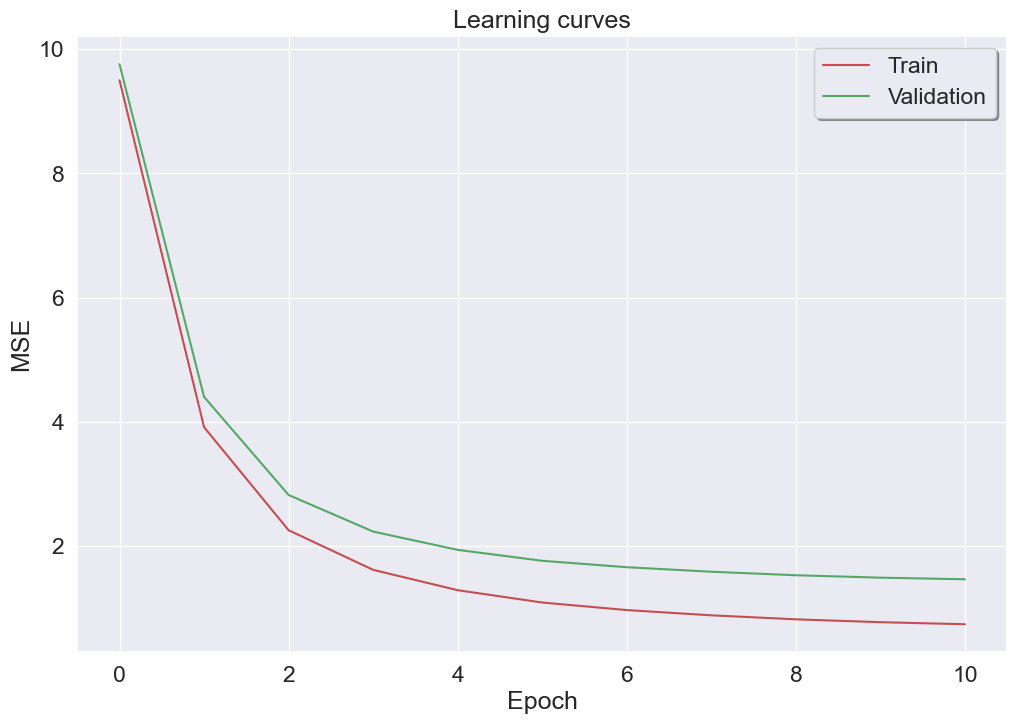

In [31]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)